In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from keras.layers import Input, Dense
from keras.models import Model
import sys
# src folder
sys.path.insert(0, "../")
# autoencoders lib
from autoencoders import get_simple_autoencoder, get_autoencoder, decode, dist_decoding_err
from utils import lift_summary, autoenc_eval_summary

## Read data

In [2]:
# The used dataset is available in https://www.kaggle.com/mlg-ulb/creditcardfraud
df = pd.read_csv("../../data/creditcard.csv")
# Show Nb rows, Nb cols
df.shape

(284807, 31)

In [3]:
# Show header
df.head()

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...         V21       V22       V23       V24  \
0  0.098698  0.363787  ...   -0.018307  0.277838 -0.110474  0.066928   
1  0.085102 -0.255425  ...   -0.225775 -0.638672  0.101288 -0.339846   
2  0.247676 -1.514654  ...    0.247998  0.771679  0.909412 -0.689281   
3  0.377436 -1.387024  ...   -0.108300  0.005274 -0.190321 -1.175575   
4 -0.270533  0.817739  ...   -0.009431  0.798278 -0.137458  0.141267   

        V25       V26       V27       V28  Amount  Class  
0  0.128539 -0.189115  0.133558 -0.021053  149.62      0  
1  0.167170  0.125895 -0.008983  0.014724    2.69      0  
2 -0.327642 -0.139097 -0.055353 -0.059752  378.66      0  
3  0.647376 -0.221929  0.062723  0.061458  123.50      0  
4 -0.206010  0.502292  0.219422  0.215153   69.99      0  

[5 rows x 31 columns]

## Exploratory analysis

In [4]:
# Review target columns - we only have 492 true observations out of almost 285K
# That means that we have a 0.17% of fraud rate in the dataset
df.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [5]:
# NA check - not a single NA in any column
# No need to handle NA
df.isna().sum().any()

False

In [6]:
# We will not do a time-dynamic analysis, so the Time columns will be dropped
df = df.drop(columns=['Time'])

### Univariate analysis

/home/sgamez/anaconda3/envs/kerasenv/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


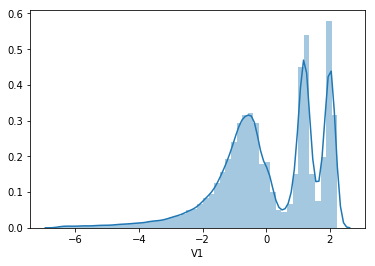

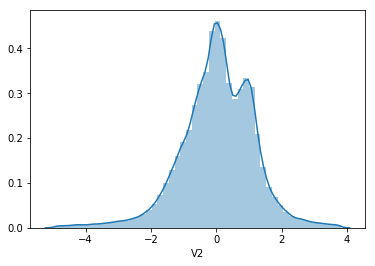

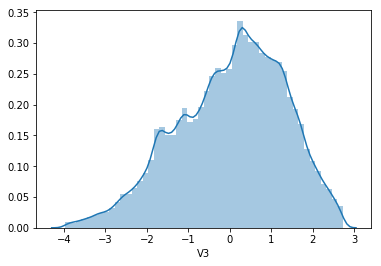

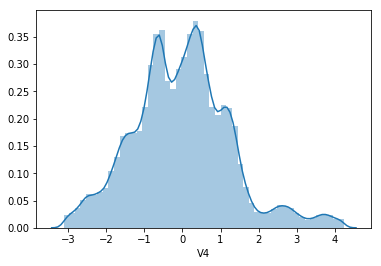

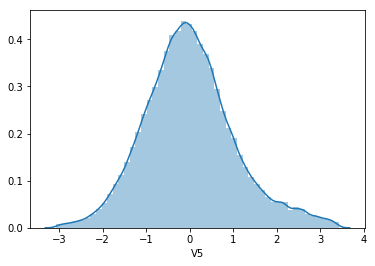

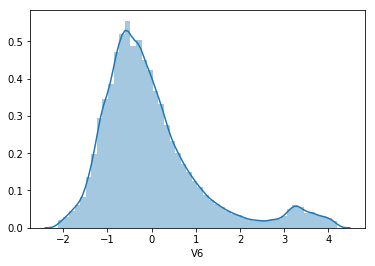

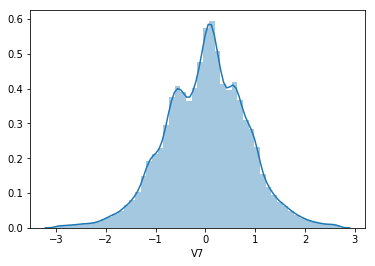

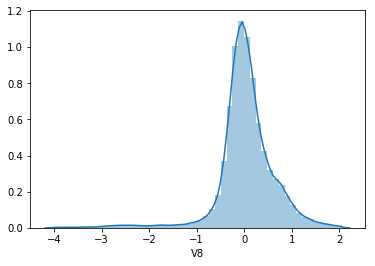

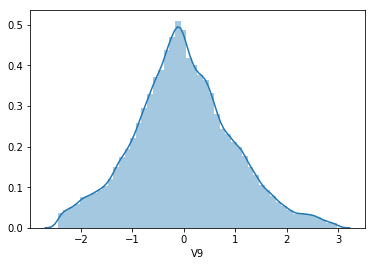

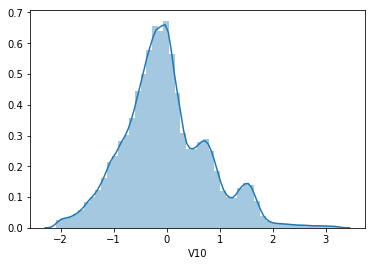

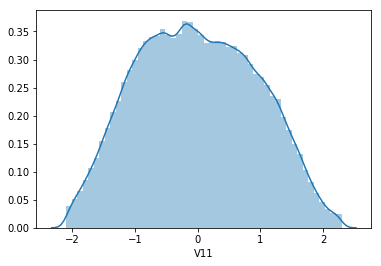

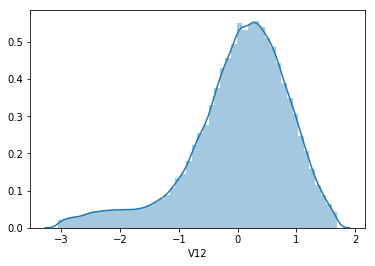

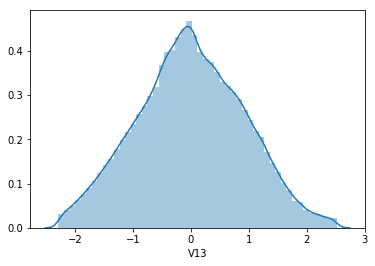

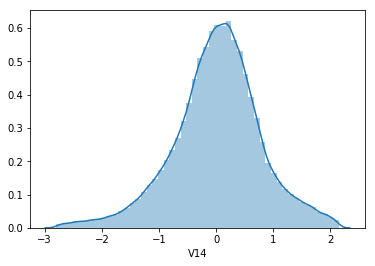

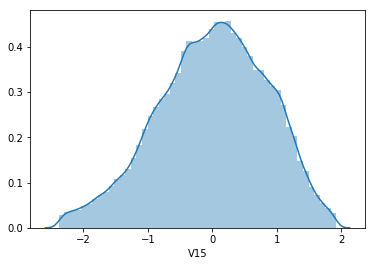

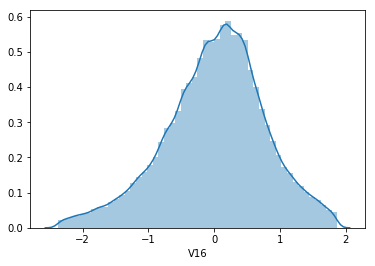

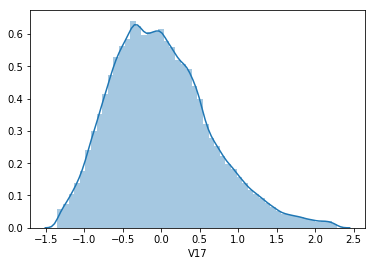

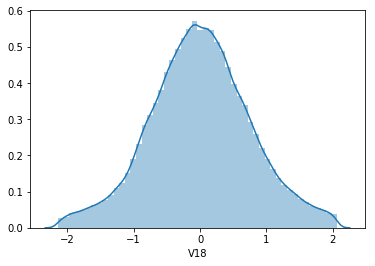

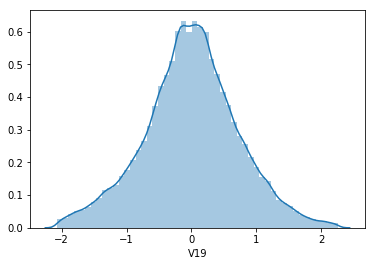

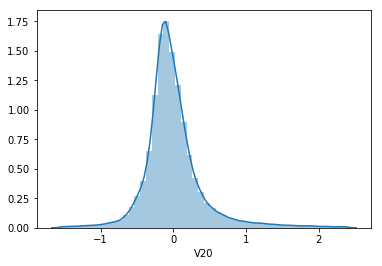

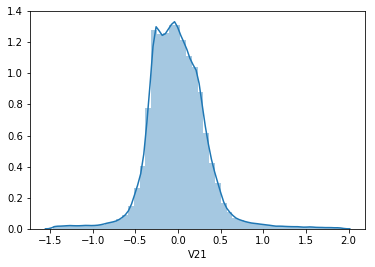

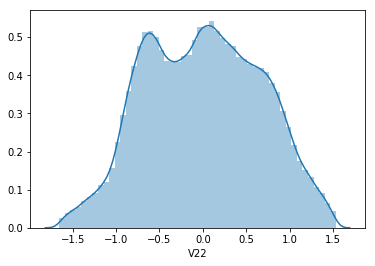

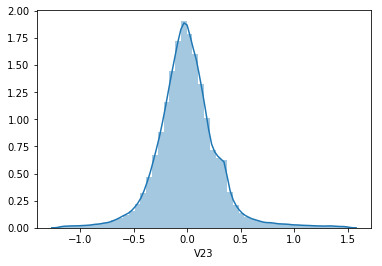

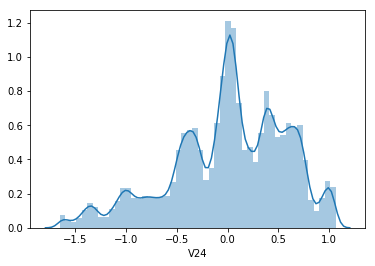

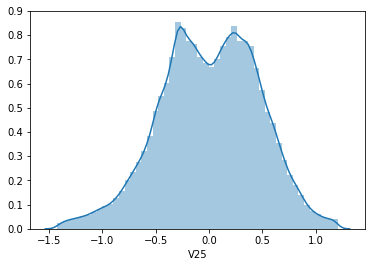

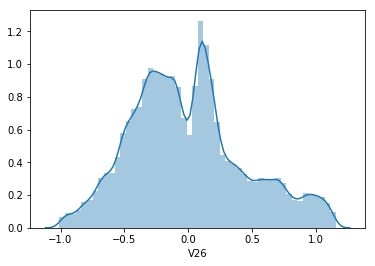

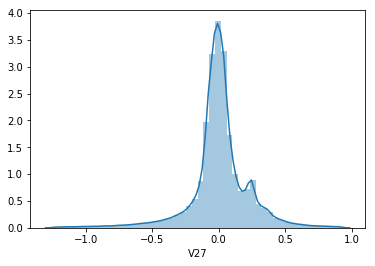

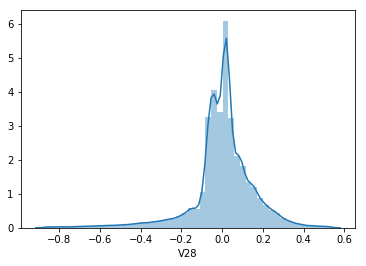

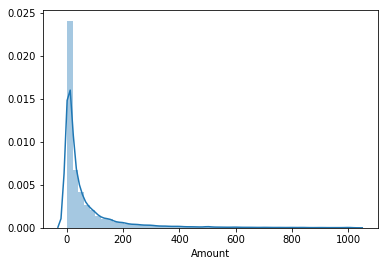

In [7]:
# Capture the target column and the features
target_col = 'Class'
features = [c for c in df.columns if c!= target_col]
# Outlier removal treshold
TH_outliers = 0.01
for feat in features:
    #drop top / bottom x% to remove outliers
    perc_cuts = df[feat].quantile(q=[TH_outliers, 1. - TH_outliers])
    feat_series = df[df[feat].between(*perc_cuts)][feat]
    sns.distplot(feat_series)
    plt.show()

### Bivariate analysis

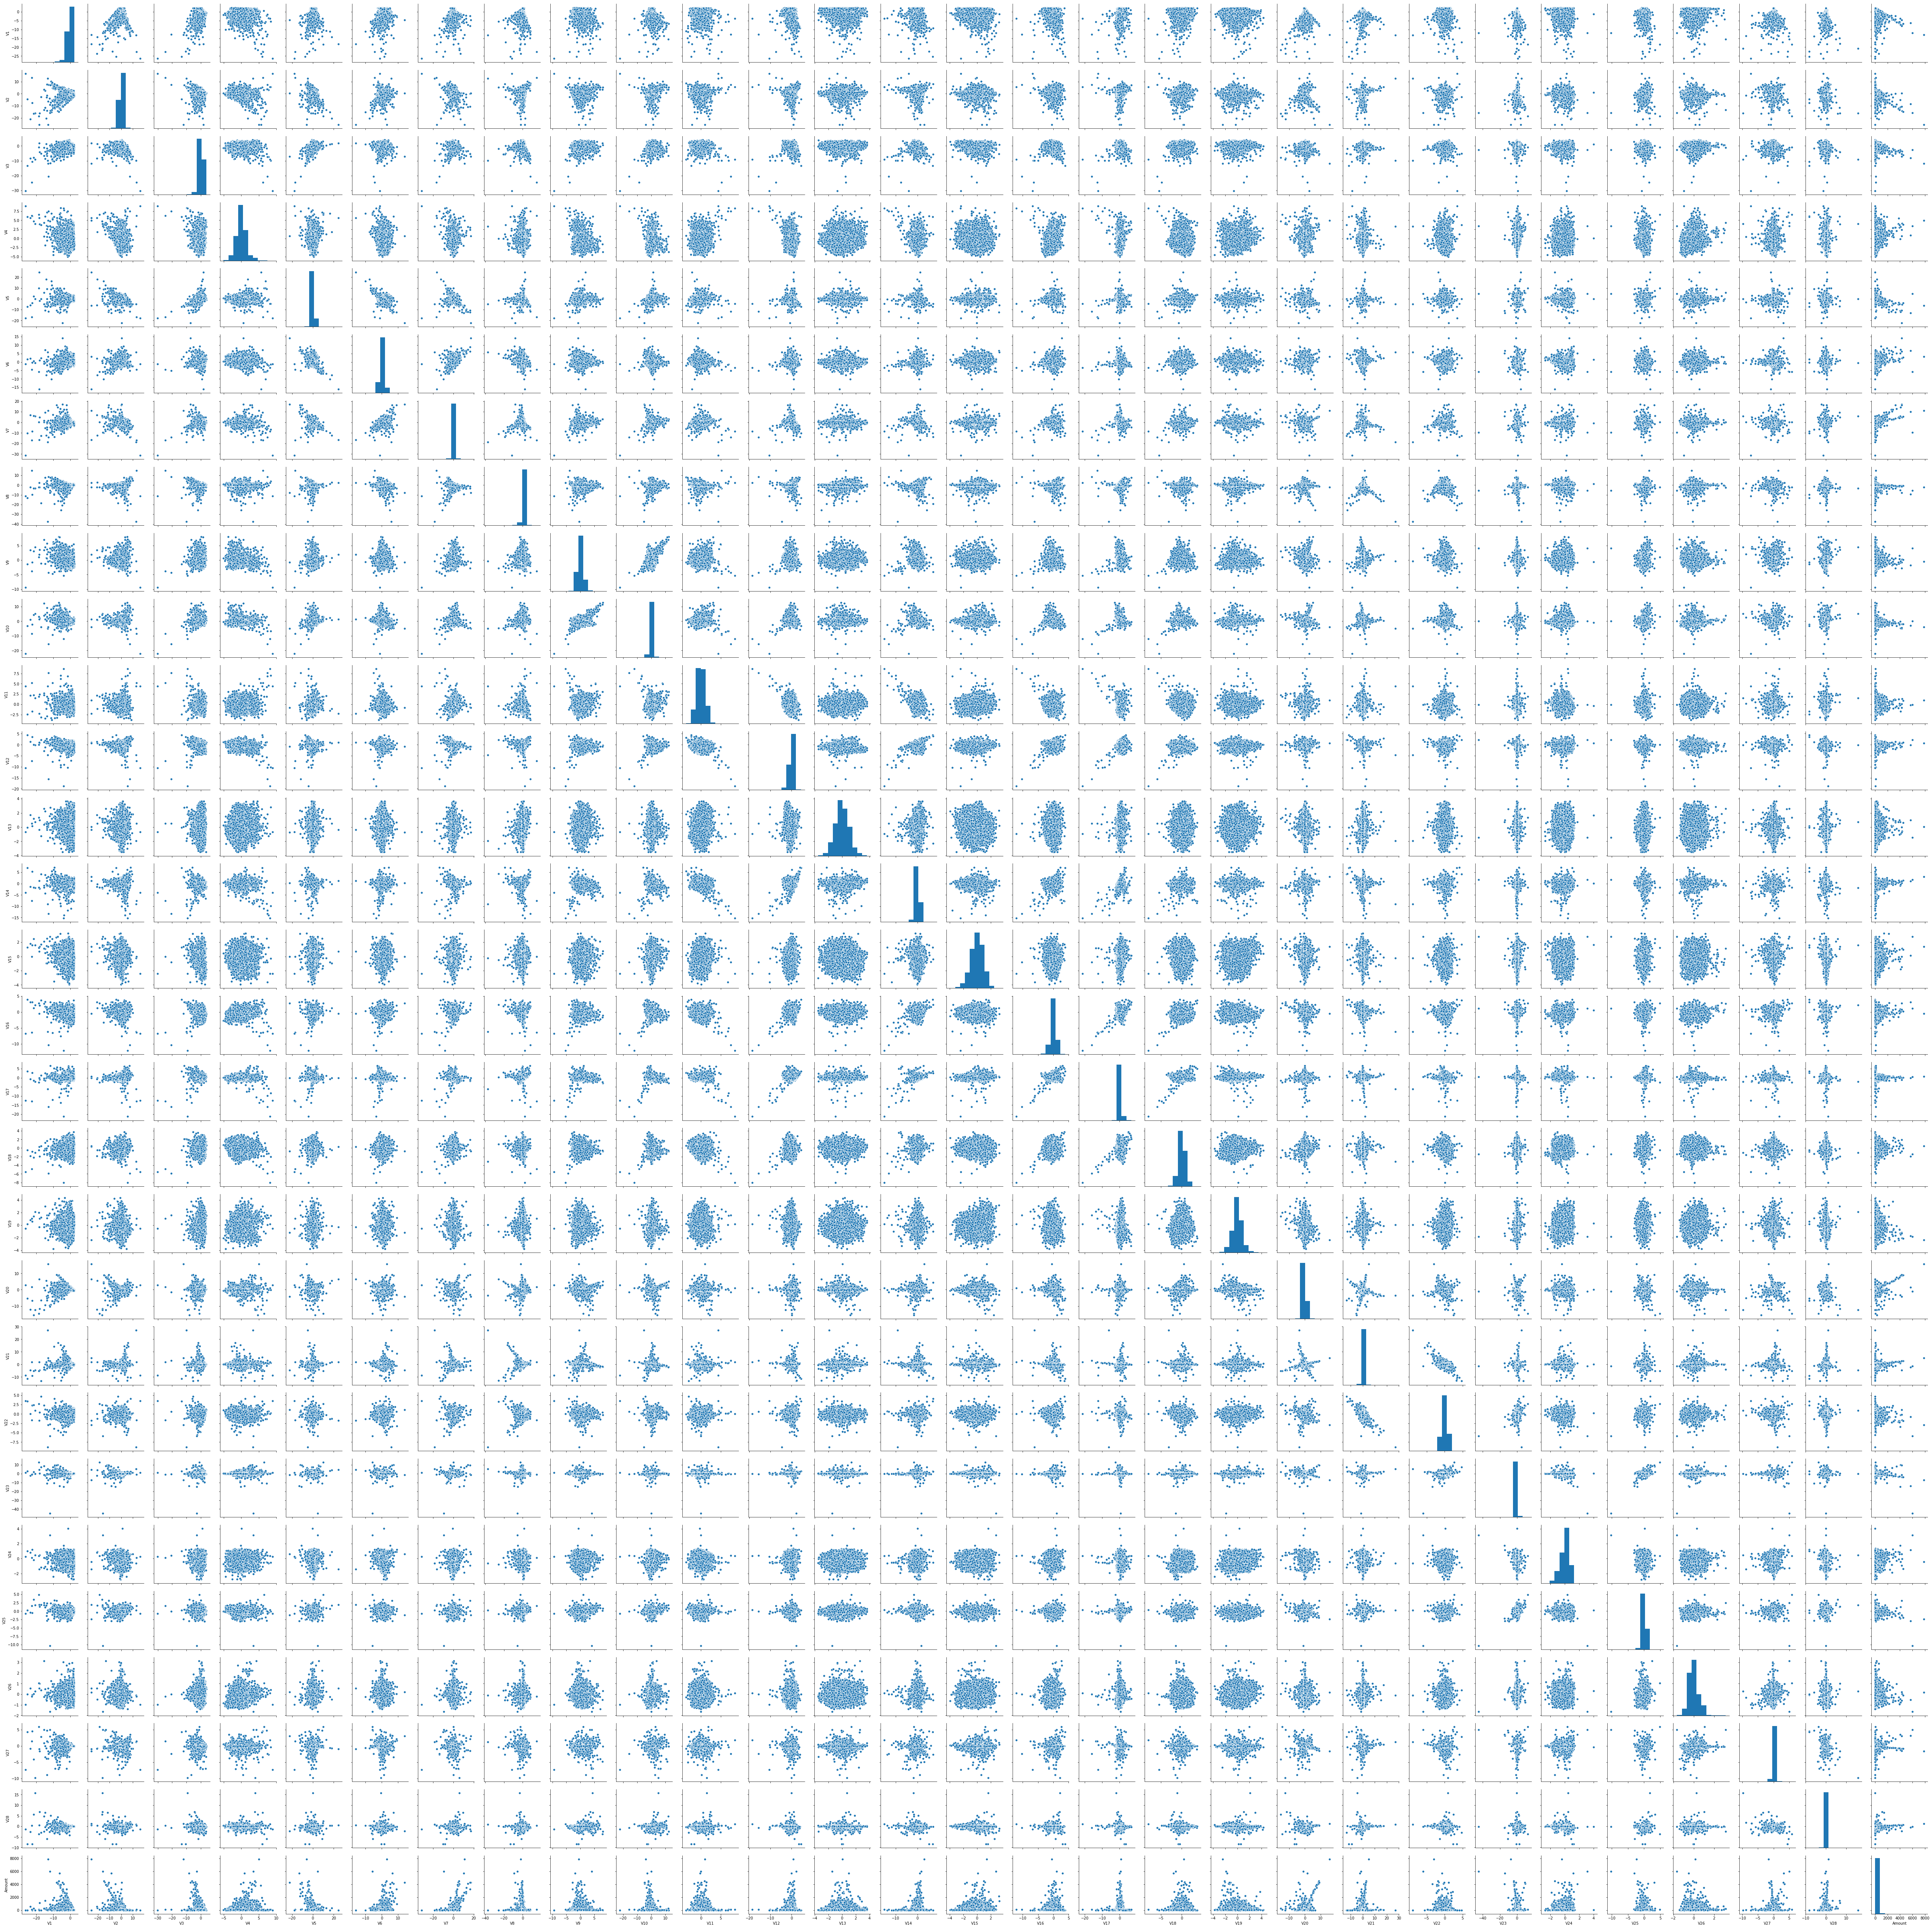

In [8]:
# Using a sample because otherwise it takes forever
sns.pairplot(df[features].sample(frac=0.05))

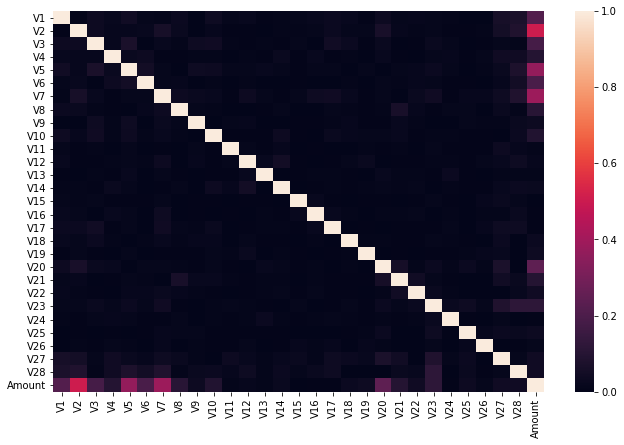

In [9]:
# Correlation plot
corr = df[features].sample(frac=0.05).corr()
plt.figure(figsize=(11, 7))
sns.heatmap(corr.abs(),
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            vmin=0.,
            vmax=1)

### Data distribution vs target feature

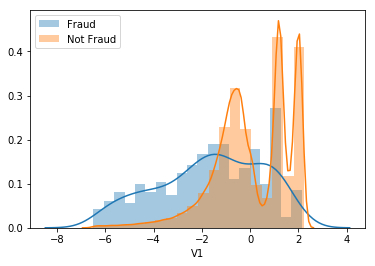

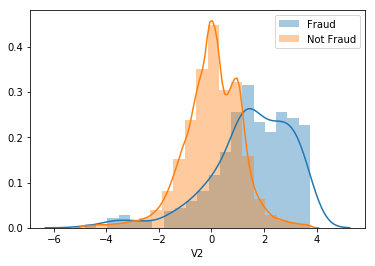

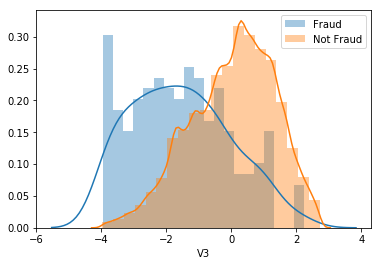

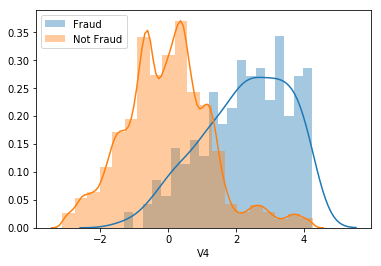

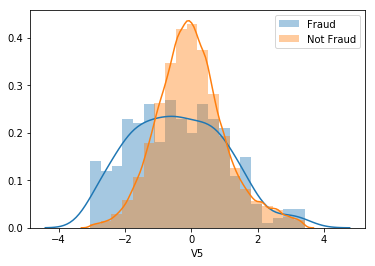

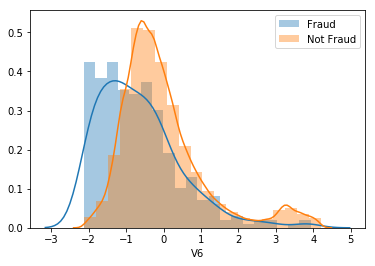

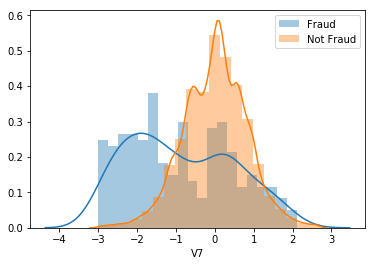

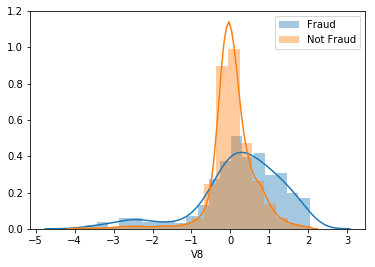

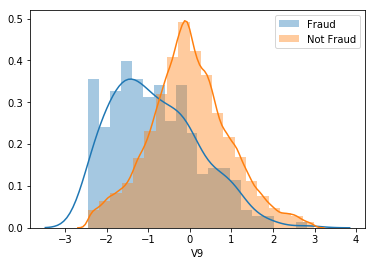

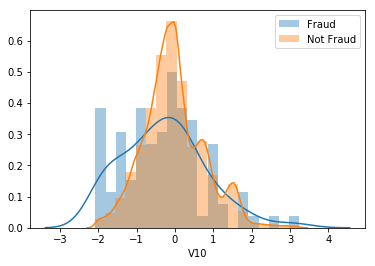

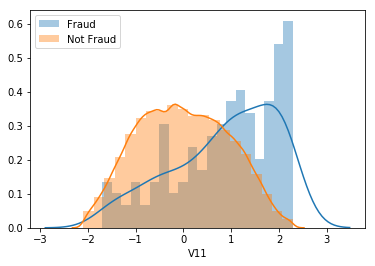

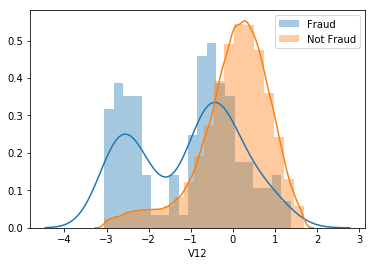

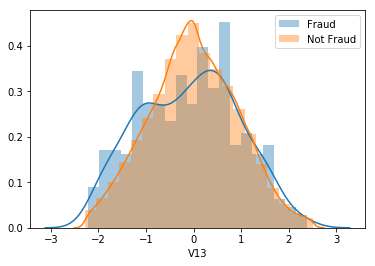

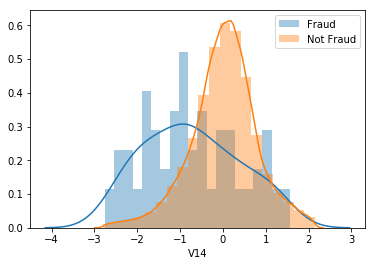

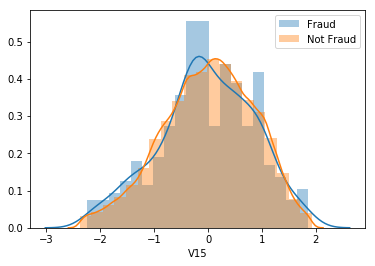

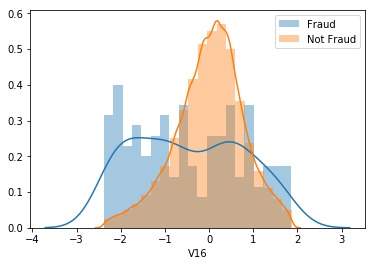

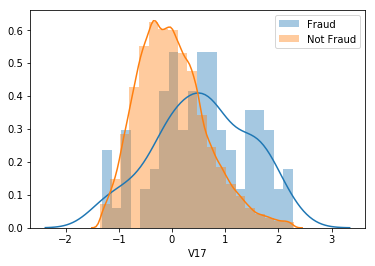

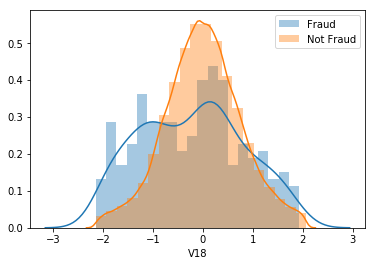

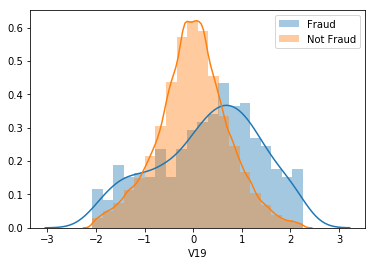

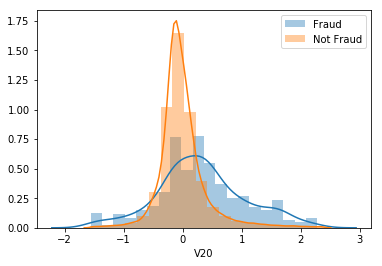

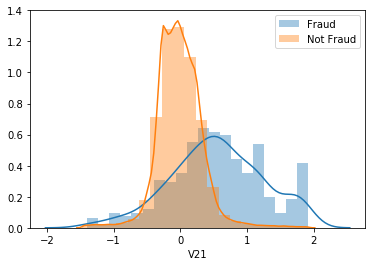

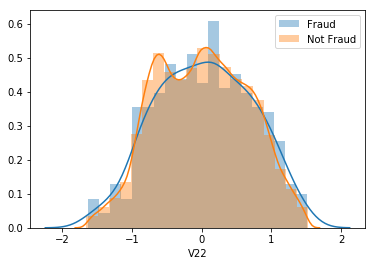

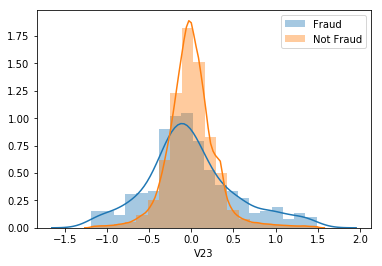

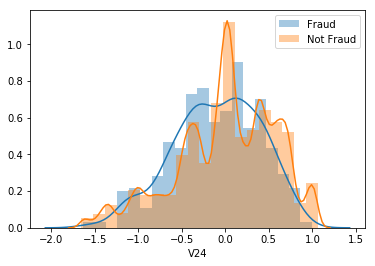

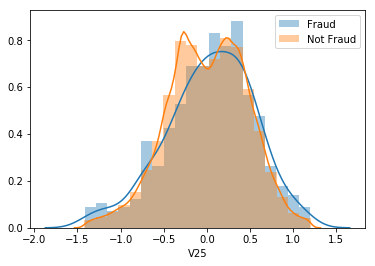

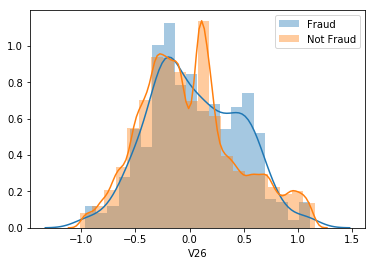

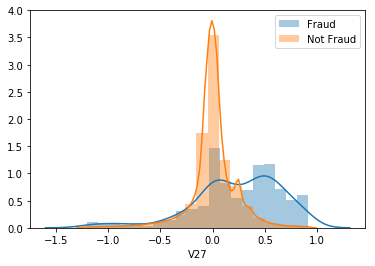

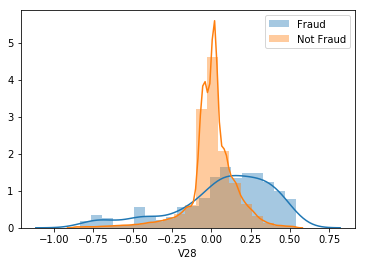

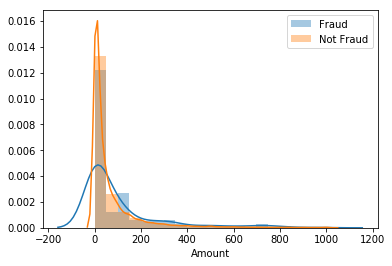

In [10]:
for feat in features:
    # drop top / bottom x% to remove outliers
    perc_cuts = df[feat].quantile(q=[TH_outliers, 1. - TH_outliers])
    df_cut = df[df[feat].between(*perc_cuts)]
    # capture fraud and not fraud entries
    series_fraud = df_cut.loc[df_cut.Class == 1][feat]
    series_nfraud = df_cut.loc[df_cut.Class == 0][feat]
    sns.distplot(series_fraud, bins=20, label='Fraud')
    sns.distplot(series_nfraud, bins=20, label='Not Fraud')
    plt.legend()
    plt.show()

## Autoencoder modelling

### Data Preparation

In [15]:
# Set the compresion factor
COMP_FACTOR = 2
# Get the data columns out of the dataframe
X_base = df[features]
# Stratified Kfold
skf = StratifiedKFold(n_splits=5)
cv_indeces = [(train, test)for train, test in skf.split(X_base, df.Class)]
# Dictionary to store preprocess data
X_prep_train, X_prep_test = {}, {}
for idx_fold, cv_fold in enumerate(cv_indeces):
    X_train, X_test = X_base.iloc[cv_fold[0]], X_base.iloc[cv_fold[1]]
    
    # Use StandardScaler in order to set mean to 0 and have unit variance
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_prep_train[idx_fold] = scaler.transform(X_train)
    X_prep_test[idx_fold] = scaler.transform(X_test)

### Base autoencoder

In [17]:
lift_tr_smp, lift_test_smp = [], []
AUC_tr_smp, AUC_test_smp = [], []

for idx_fold, cv_fold in enumerate(cv_indeces):
    print ("Working for fold: {}".format(idx_fold))
    X_train, X_test = X_prep_train[idx_fold], X_prep_test[idx_fold]
    y_train, y_test = df.Class.iloc[cv_fold[0]], df.Class.iloc[cv_fold[1]]
    # Initialize and fit 
    smp_autoencoder, smp_encoder, smp_decoder = get_simple_autoencoder(X_train, COMP_FACTOR)
    smp_autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    smp_autoencoder.fit(X_train, X_train,
                    epochs=50,
                    batch_size=128,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=0)
    # Get reconstruction error
    dist_tr_smp = dist_decoding_err(X_train, smp_encoder, smp_decoder)
    dec_test_smp = dist_decoding_err(X_test, smp_encoder, smp_decoder)
    # Get evaluation metrics
    lift_tr, lift_test, AUC_tr, AUC_test = autoenc_eval_summary(y_train, y_test, dist_tr_smp, dec_test_smp)
    # Store them
    lift_tr_smp.append(lift_tr), lift_test_smp.append(lift_test)
    AUC_tr_smp.append(AUC_tr), AUC_test_smp.append(AUC_test)

Working for fold: 0
Working for fold: 1
Working for fold: 2
Working for fold: 3
Working for fold: 4


### Autoencoder with hidden layer

In [ ]:
lift_tr, lift_test = [], []
AUC_tr, AUC_test = [], []

for idx_fold, cv_fold in enumerate(cv_indeces):
    print ("Working for fold: {}".format(idx_fold))
    X_train, X_test = X_prep_train[idx_fold], X_prep_test[idx_fold]
    y_train, y_test = df.Class.iloc[cv_fold[0]], df.Class.iloc[cv_fold[1]]
    # Auto encoder initialization
    autoencoder, encoder, decoder = get_autoencoder(X_train, COMP_FACTOR)
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    autoencoder.fit(X_train, X_train,
                    epochs=30,
                    batch_size=128,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=0)
    # Get reconstruction error
    dist_tr = dist_decoding_err(X_train, encoder, decoder)
    dist_test = dist_decoding_err(X_test, encoder, decoder)
    # Get lift metric
    lift_tr_ = lift_summary(dist_tr, y_train)
    lift_test_ = lift_summary(dist_test, y_test)
    # Get AUC metric
    AUC_tr_ = roc_auc_score(y_train, dist_tr)
    AUC_test_ = roc_auc_score(y_test, dist_test)
    # Store them
    lift_tr.append(lift_tr_), lift_test.append(lift_test_)
    AUC_tr.append(AUC_tr_), AUC_test.append(AUC_test_)

Working for fold: 0
Working for fold: 1
Working for fold: 2


## Evaluation

### Lift evaluation

In [ ]:
# TODO

### AUC

In [ ]:
# TODO